# Cardiotocography Modeling Workshop

Building clinically grounded classifiers on the engineered CTG feature table.

## Reusing the cleaned dataset
We start by reproducing the cleaned feature matrix and stratified train/test split from the exploration notebook so every model shares identical inputs and evaluation splits.

In [11]:
# Core libraries and model APIs
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

In [13]:
# Load and tidy the engineered feature sheet
ctg_path = Path("../cardiotocography/CTG.xls")
assert ctg_path.exists(), f"Expected Excel file at {ctg_path.resolve()}"

def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    sheet_name = xls.sheet_names[sheet] if isinstance(sheet, int) else sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df

raw_features = read_feature_sheet(ctg_path, sheet=1)
raw_features.shape

(2129, 46)

In [14]:
# Clean columns, drop leakage, and ensure numerics
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned

sheet2 = tidy_sheet(raw_features)
target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
feature_cols = [col for col in sheet2.columns if col not in label_leak_cols + [target_col]]
clean_df = (
    sheet2
    .drop(columns=label_leak_cols, errors='ignore')
    .dropna(axis=0, how='all')
    .drop_duplicates()
)

# Coerce numeric columns and drop rows without labels
numeric_cols = feature_cols
clean_df[numeric_cols] = clean_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
clean_df = clean_df.dropna(subset=[target_col]).copy()
clean_df[target_col] = clean_df[target_col].astype(int)

X = clean_df[numeric_cols]
y = clean_df[target_col]
X.shape, y.value_counts().sort_index()

((2115, 30),
 NSP
 1    1647
 2     293
 3     175
 Name: count, dtype: int64)

In [29]:
X.head()


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,64.00,62.00,126.00,2.00,0.00,120.00,137.00,121.00,73.00,1.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,130.00,68.00,198.00,6.00,1.00,141.00,136.00,140.00,12.00,0.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,130.00,68.00,198.00,5.00,1.00,141.00,135.00,138.00,13.00,0.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,117.00,53.00,170.00,11.00,0.00,137.00,134.00,137.00,13.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,117.00,53.00,170.00,9.00,0.00,137.00,136.00,138.00,11.00,1.00


In [15]:
# Stratified train/test split and class weights
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
classes = np.unique(y_train)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight_values))
sample_weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')
)
distribution, class_weight_dict

(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1480                   0.78                    0.14   
 1   Test   635                   0.78                    0.14   
 
    Pathologic (3) proportion  
 0                       0.08  
 1                       0.08  ,
 {np.int64(1): np.float64(0.4278693263949118),
  np.int64(2): np.float64(2.4065040650406506),
  np.int64(3): np.float64(4.043715846994536)})

## Clinical guardrails before modeling
- **Minimize false negatives on `NSP=3` (pathologic):** models that miss hypoxic fetuses jeopardize neonatal outcomes; threshold tuning should bias toward recall for class 3.
- **Respect the grey zone (`NSP=2` suspect):** it's acceptable to flag more suspects if it reduces misses on class 3, but overwhelming clinicians with false alarms erodes trust.
- **Transparent decision support:** whenever possible, expose feature influence (weights, splits, importances) to help clinicians corroborate model output with CTG traces.
- **Latency & deployment practicality:** bedside triage demands sub-second inference; heavy models must justify their cost with clear performance gains.

## Evaluation focus
We will report **balanced accuracy** (accounts for class imbalance) and **macro F1** (treats each class equally) for every model to highlight performance on rare but critical pathologic traces.

In [16]:
# Shared evaluation helper
results = []

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    fit_kwargs = fit_kwargs or {}
    estimator.fit(X_train, y_train, **fit_kwargs)
    y_pred = estimator.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1})
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}")
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()
    return estimator, y_pred

classes

array([1, 2, 3])

## Logistic Regression
**How it works**
- Optimizes a multinomial logistic loss to find weights that maximize the likelihood of observed labels, effectively fitting linear decision boundaries in feature space.
- Converts weighted sums into calibrated class probabilities via the logistic (softmax) function, giving interpretable coefficients.
- Decision boundary is a hyperplane; regularization (here implicit via solver) prevents exploding weights on collinear features.

**Pros**
- Coefficients map directly to clinical features, aiding transparency and threshold adjustments.
- Fast to train and update, making it easy to deploy or re-fit as new CTG data arrives.
- With class-balanced weighting it remains resilient to moderate imbalance.

**Cons**
- Fails to capture non-linear feature interactions that often signal fetal compromise (e.g., low baseline *and* high decelerations).
- Needs standardized inputs to avoid scale-dominant coefficients.
- Susceptible to residual class overlap—suspect cases may remain ambiguous.

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression — Balanced Accuracy: 0.831, Macro F1: 0.786
              precision    recall  f1-score   support

           1      0.980     0.889     0.932       494
           2      0.549     0.830     0.661        88
           3      0.759     0.774     0.766        53

    accuracy                          0.871       635
   macro avg      0.763     0.831     0.786       635
weighted avg      0.902     0.871     0.881       635



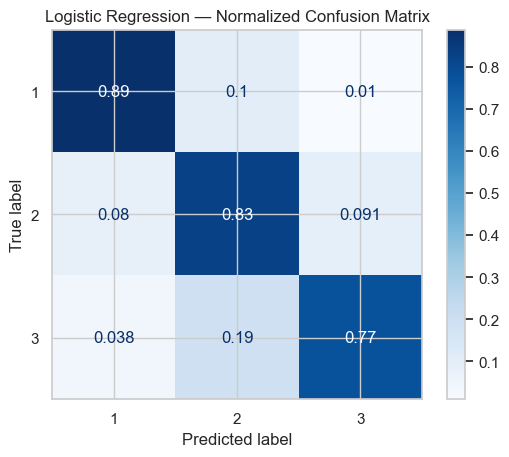

In [17]:
log_reg_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        class_weight='balanced',
        solver='lbfgs'
    ))
])
_ = evaluate_model('Logistic Regression', log_reg_pipeline, X_train, y_train, X_test, y_test, display_report=True)

## Decision Tree
**How it works**
- Recursively partitions the feature space with binary questions (e.g., `ASTV > 75`) chosen to maximize class purity (Gini impurity by default).
- Creates a tree structure where each leaf stores the majority class (and probabilities).
- Depth and leaf size control the granularity of decision rules.

**Pros**
- Individual splits map cleanly to clinical heuristics, making the reasoning easy to explain.
- Captures non-linear thresholds and feature interactions without feature engineering.
- No scaling required and robust to monotonic transformations.

**Cons**
- Overfits if left unchecked; here we regularize with `min_samples_leaf`.
- Small data perturbations can reshape the tree (high variance).
- Performance ceiling lower than ensembles due to single-path decisions.

Decision Tree — Balanced Accuracy: 0.872, Macro F1: 0.839


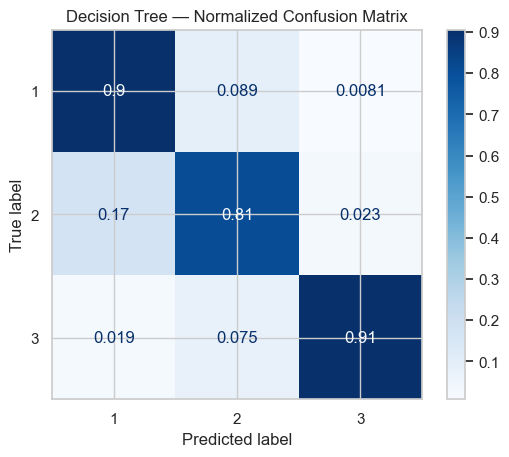

In [ ]:
tree_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('tree', DecisionTreeClassifier(
        criterion='gini',
        min_samples_leaf=5,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])
_ = evaluate_model('Decision Tree', tree_pipeline, X_train, y_train, X_test, y_test)

## Random Forest
**How it works**
- Trains many decision trees on bootstrapped samples of the training data and random subsets of features at each split to decorrelate the trees.
- Aggregates predictions by majority vote (classification) for robustness.
- Feature importance emerges from averaged impurity reduction across trees.

**Pros**
- Strong default accuracy on tabular data with minimal tuning.
- Handles class imbalance better than a single tree, especially with class weights.
- Provides global feature importance for clinician-facing summaries.

**Cons**
- Harder to interpret individual decisions compared with a single tree.
- Larger ensembles increase inference latency and memory footprint.
- Can still be biased toward majority class without weighting (addressed here).

Random Forest — Balanced Accuracy: 0.915, Macro F1: 0.911


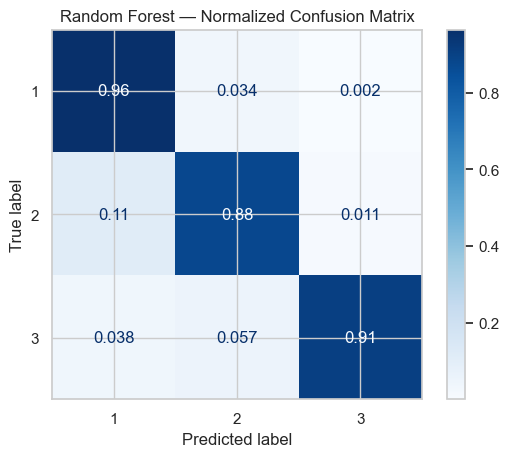

In [19]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
_ = evaluate_model('Random Forest', rf_pipeline, X_train, y_train, X_test, y_test)

## Gradient Boosting
**How it works**
- Builds trees sequentially, each new tree focusing on the residual errors of the ensemble-so-far (gradients of the loss).
- Uses learning rate shrinking so that many small trees collectively approximate complex decision surfaces.
- Our scikit-learn implementation optimizes deviance loss for probabilistic outputs.

**Pros**
- High accuracy on structured data with modest feature counts.
- Naturally highlights hardest-to-classify samples, often improving minority-class sensitivity.
- Feature importance and SHAP values can expose nuanced interactions.

**Cons**
- Sensitive to hyperparameters (learning rate, depth, number of estimators).
- Training is sequential, so slower than forests (no parallel tree building).
- Requires careful monitoring for overfitting, especially on small datasets.

Gradient Boosting — Balanced Accuracy: 0.911, Macro F1: 0.921


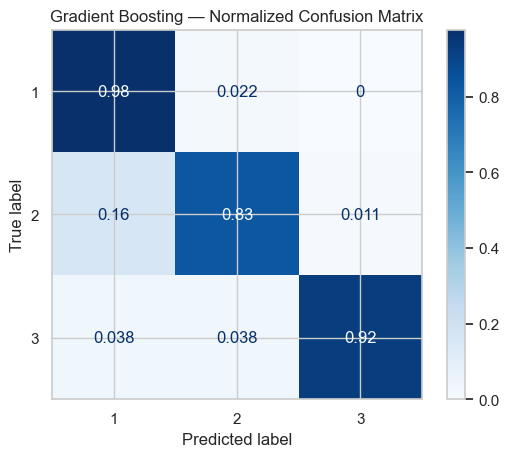

In [20]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train, X_test, y_test, fit_kwargs=gb_fit_kwargs)

## Support Vector Machine (SVM)
**How it works**
- Constructs a maximal-margin hyperplane in a transformed feature space; here an RBF kernel lifts data into higher dimensions.
- Only support vectors (points near the decision boundary) define the hyperplane, making the solution sparse.
- Class weighting shifts the margin to favour recall on minority classes.

**Pros**
- Excellent at carving clear margins when classes are separable in kernel space.
- Effective on medium-sized tabular datasets without extensive tuning.
- Margins reduce overfitting in high-dimensional settings.

**Cons**
- Requires scaled inputs for stable kernel evaluations.
- Training time grows quickly with sample size and number of support vectors.
- Harder to interpret—kernel trick obscures feature contributions.

Support Vector Machine — Balanced Accuracy: 0.857, Macro F1: 0.825


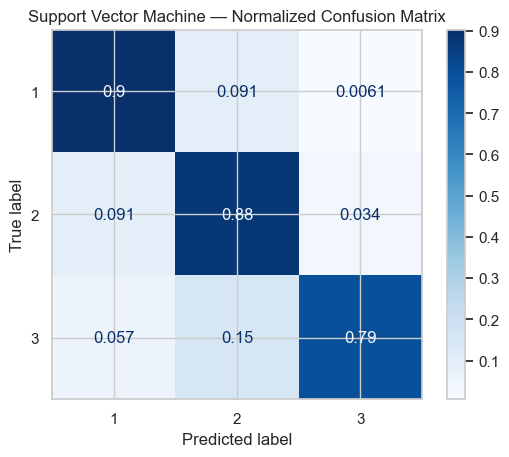

In [21]:
svm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=2.0,
        gamma='scale',
        class_weight='balanced'
    ))
])
_ = evaluate_model('Support Vector Machine', svm_pipeline, X_train, y_train, X_test, y_test)

## Neural Network (MLP)
**How it works**
- Stacks fully connected layers; each neuron applies a linear transformation followed by a non-linear activation (ReLU) to learn hierarchical feature abstractions.
- Backpropagation adjusts weights to minimize cross-entropy loss, with early stopping preventing overfit.
- Hidden layers allow complex, non-linear decision boundaries beyond tree ensembles.

**Pros**
- Flexible function approximator capable of capturing subtle feature interactions.
- Early stopping and adaptive learning rate stabilize training on limited data.
- Probabilistic outputs suitable for risk stratification thresholds.

**Cons**
- Acts as a black box; internal representations are difficult to interpret clinically.
- Sensitive to feature scaling and weight initialization.
- Overfitting risk on small datasets; requires careful regularization and monitoring.

Neural Network (MLP) — Balanced Accuracy: 0.801, Macro F1: 0.832


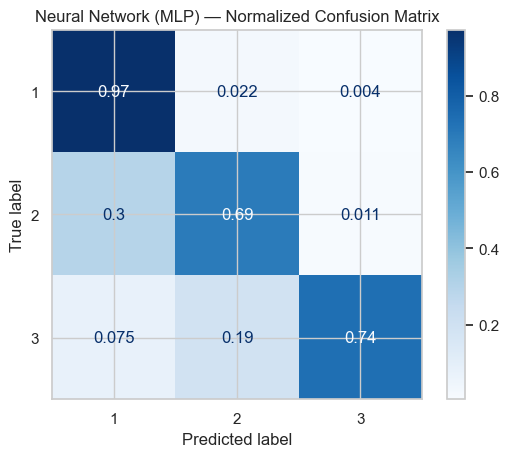

In [22]:
mlp_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-3,
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])
_ = evaluate_model('Neural Network (MLP)', mlp_pipeline, X_train, y_train, X_test, y_test)

## k-Nearest Neighbors (kNN)
**How it works**
- Stores the entire training set; to classify a new point, finds the `k` closest samples (using Euclidean distance after scaling) and assigns the majority label.
- No training phase beyond storing data; prediction cost scales with dataset size.
- Distance weighting can refine voting, though we use uniform weights for clarity.

**Pros**
- Conceptually intuitive for workshop demos; decision boundary follows the data manifold.
- Non-parametric—adapts as more CTG cases are added without retraining.
- Performs well when relevant features are well-scaled and informative.

**Cons**
- Prediction latency grows with dataset size; unsuitable for large real-time deployments.
- Sensitive to noisy features and requires scaling to prevent dominance by high-variance variables.
- Choice of `k` crucial; small `k` overfits, large `k` underfits minority classes.

k-Nearest Neighbors — Balanced Accuracy: 0.722, Macro F1: 0.771


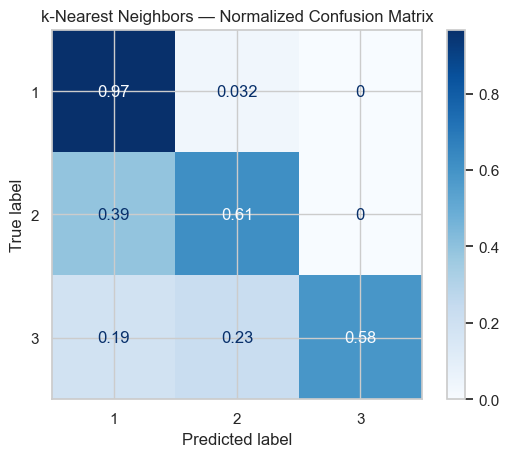

In [23]:
knn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15))
])
_ = evaluate_model('k-Nearest Neighbors', knn_pipeline, X_train, y_train, X_test, y_test)

In [24]:
# Aggregate model performance
results_df = pd.DataFrame(results).sort_values('Balanced Accuracy', ascending=False)
results_df.reset_index(drop=True)

,Model,Balanced Accuracy,F1 Macro
0,Random Forest,0.91,0.91
1,Gradient Boosting,0.91,0.92
2,Decision Tree,0.87,0.84
3,Support Vector Machine,0.86,0.83
4,Logistic Regression,0.83,0.79
5,Neural Network (MLP),0.80,0.83
6,k-Nearest Neighbors,0.72,0.77


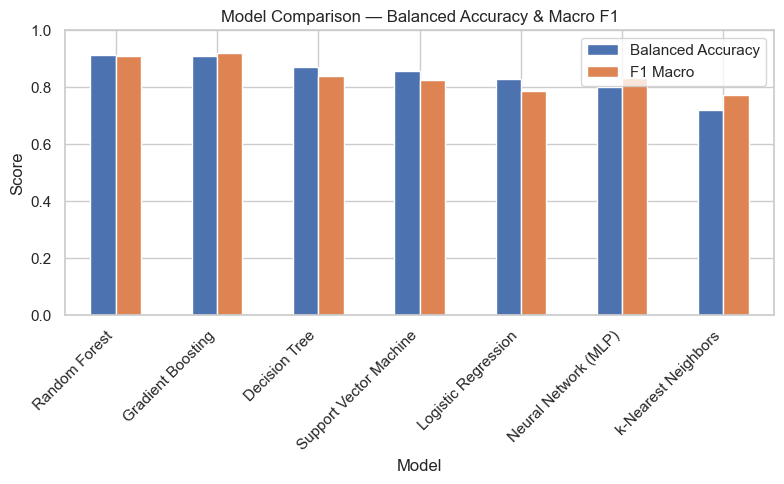

In [ ]:
# Visual comparison
fig, ax = plt.subplots(figsize=(8, 5))
results_df.plot(x='Model', y=['Balanced Accuracy', 'F1 Macro'], kind='bar', ax=ax)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Model Comparison — Balanced Accuracy & Macro F1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()